https://www.tensorflow.org/tutorials/structured_data/time_series

In [0]:
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# **Part 0: Data Loading & Preprocessing**

In [0]:
df = pd.read_csv("sales_train_validation_CA_only.csv")
df1 = df.drop(['id', 'item_id', 'dept_id', 'cat_id', 'state_id'], axis=1)
df1 = df1.groupby(['store_id']).sum()
df1.index.names = [None]
df1 = df1.transpose()
df1.index = np.arange(1,len(df1)+1)
df1.reset_index(inplace=True)
df1.rename(columns={"index": "Day"}, inplace=True)

In [0]:
df1.shape

(1913, 5)

In [0]:
df1.head()

,Day,CA_1,CA_2,CA_3,CA_4
0,1,4337,3494,4739,1625
1,2,4155,3046,4827,1777
2,3,2816,2121,3785,1386
3,4,3051,2324,4232,1440
4,5,2630,1942,3817,1536


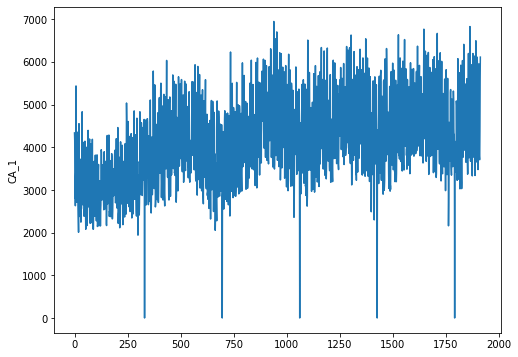

In [0]:
sns.lineplot(x=df1.index, y="CA_1", data=df1);

In [0]:
TRAIN_SIZE = int(len(df1) * 0.9)
test_size = len(df1) - TRAIN_SIZE
train, test = df1.iloc[0:TRAIN_SIZE], df1.iloc[TRAIN_SIZE:len(df1)]
print(len(train), len(test))

1721 192


In [0]:
train.head()

,Day,CA_1,CA_2,CA_3,CA_4
0,1,4337,3494,4739,1625
1,2,4155,3046,4827,1777
2,3,2816,2121,3785,1386
3,4,3051,2324,4232,1440
4,5,2630,1942,3817,1536


In [0]:
test.head()

,Day,CA_1,CA_2,CA_3,CA_4
1721,1722,4122,4189,5769,2169
1722,1723,5582,5870,7446,2866
1723,1724,6214,5895,8037,2941
1724,1725,4094,3292,6022,2597
1725,1726,3717,3246,5514,2511


In [0]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

In [0]:
'''Setting seed to ensure reproducibility'''

tf.random.set_seed(13)

# **Part 1: Forecast a univariate time series (CA_1)**

In [0]:
'''Let's first extract only CA_1 from the dataset'''

uni_data = df1['CA_1']
uni_data.index = df1['Day']
uni_data.head()

Day
1    4337
2    4155
3    2816
4    3051
5    2630
Name: CA_1, dtype: int64

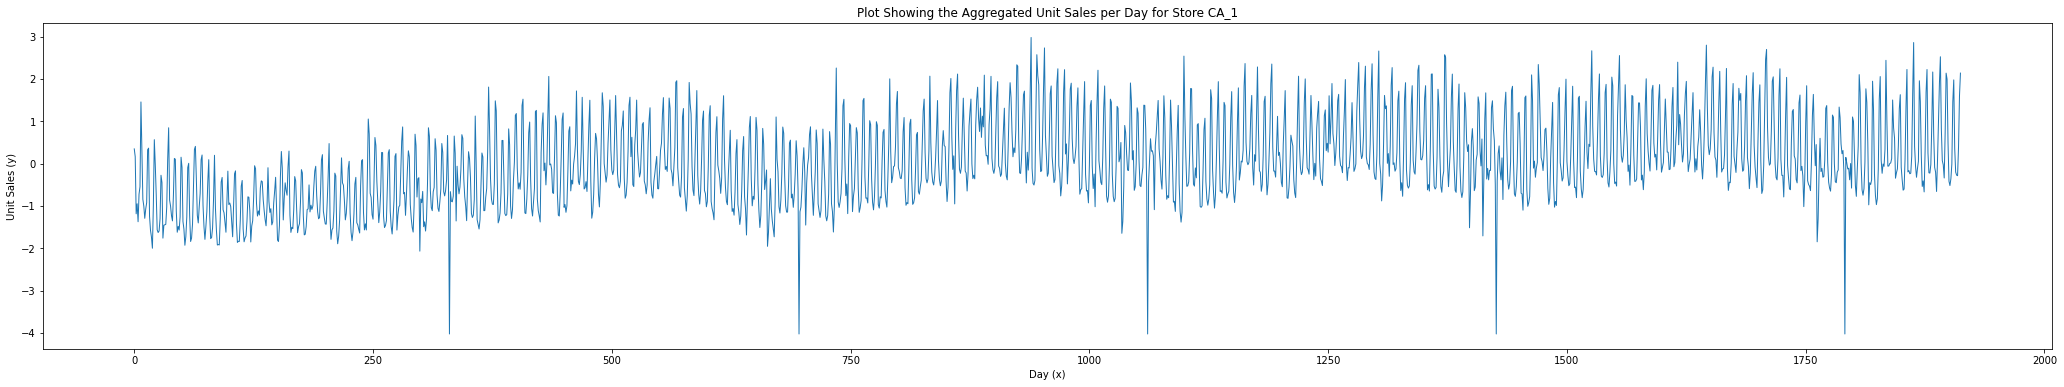

In [0]:
'''Let's observe how this data looks across time'''
plt.figure(figsize=(36, 6))
plt.plot(uni_data, linewidth=1)
plt.ylabel('Unit Sales (y)')
plt.xlabel('Day (x)')
plt.title('Plot Showing the Aggregated Unit Sales per Day for Store CA_1')
plt.show()

In [0]:
uni_data = uni_data.values

In [0]:
'''Let's standardize the data'''

uni_train_mean = uni_data[:TRAIN_SIZE].mean()
uni_train_std = uni_data[:TRAIN_SIZE].std()

uni_data = (uni_data-uni_train_mean)/uni_train_std
# uni_data[:TRAIN_SIZE]

In [0]:
'''Let's now create the data for the univariate model'''

univariate_past_history = 20
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SIZE,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SIZE, None,
                                       univariate_past_history,
                                       univariate_future_target)

In [0]:
'''This is what the univariate_data function returns'''

print ('Single window of past history')
print (x_train_uni[0])
print ('\n Target to predict')
print (y_train_uni[0])

Single window of past history
[[ 3.45967837e-01]
 [ 1.62517065e-01]
 [-1.18715647e+00]
 [-9.50283222e-01]
 [-1.37463913e+00]
 [-7.23489685e-01]
 [-5.48102684e-01]
 [ 1.45473624e+00]
 [ 3.48991751e-01]
 [-8.43438267e-01]
 [-1.00672961e+00]
 [-1.29400143e+00]
 [-1.07426369e+00]
 [-9.23067998e-01]
 [ 3.24800441e-01]
 [ 3.63103349e-01]
 [-1.24662678e+00]
 [-1.57623338e+00]
 [-1.73549285e+00]
 [-2.00058929e+00]
 [-9.86570188e-01]
 [ 5.63689633e-01]
 [-2.79895057e-02]
 [-7.35585341e-01]
 [-1.56514570e+00]
 [-1.62965586e+00]
 [-1.59236092e+00]
 [-1.30307317e+00]
 [-2.76958411e-01]
 [-4.49321499e-01]
 [-1.76170010e+00]
 [-1.45628480e+00]
 [-1.44620509e+00]
 [-1.43713335e+00]
 [-1.02386513e+00]
 [ 1.03046760e-01]
 [ 8.44913618e-01]
 [-8.62589721e-01]
 [-1.00471367e+00]
 [-1.23150721e+00]
 [-1.35447970e+00]
 [-7.50704910e-01]
 [ 1.21190243e-01]
 [ 1.01030818e-01]
 [-1.12264631e+00]
 [-1.62260006e+00]
 [-1.48350003e+00]
 [-1.57119353e+00]
 [-1.25973040e+00]
 [ 1.49413439e-01]
 [-9.04837247e-02]
 

In [0]:
'''Now that the data has been created, let's take a look at a single example'''

def create_time_steps(length):
  return list(range(-length, 0))

In [0]:
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

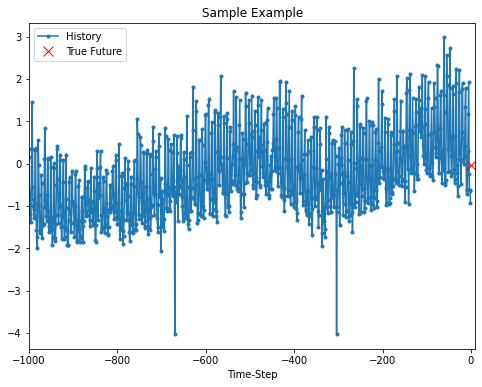

In [0]:
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')

## **Baseline**

In [0]:
def baseline(history):
  return np.mean(history)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

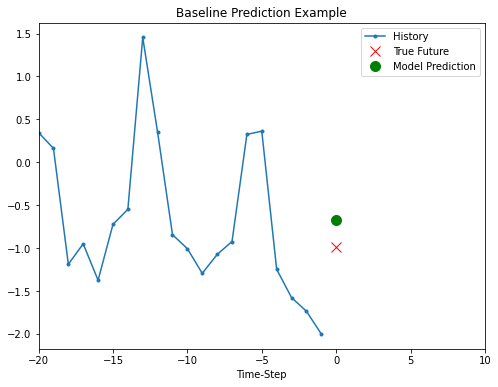

In [0]:
show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0,
           'Baseline Prediction Example')

## **Recurrent Neural Network (RNN)**

In [0]:
'''Let's now use tf.data to shuffle, batch, and cache the dataset'''

BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

In [0]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')

In [0]:
'''Let's make a sample prediction, to check the output of the model'''

for x, y in val_univariate.take(1):
    print(simple_lstm_model.predict(x).shape)

(172, 1)


In [0]:
'''Let's train the model now'''

EVALUATION_INTERVAL = 50
EPOCHS = 10

simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps=10)


#### USE THIS IF I WANT TO ADD STEPS PER EPOCH IF THE DATA PROVE TO BE TOO LARGE
# simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
#                       steps_per_epoch=EVALUATION_INTERVAL,
#                       validation_data=val_univariate, validation_steps=50)

Epoch 1/10
50/50 [==============================] - 1s 18ms/step - loss: 0.7449 - val_loss: 0.7269
Epoch 2/10
50/50 [==============================] - 0s 10ms/step - loss: 0.7068 - val_loss: 0.7240
Epoch 3/10
50/50 [==============================] - 0s 10ms/step - loss: 0.6938 - val_loss: 0.7069
Epoch 4/10
50/50 [==============================] - 1s 10ms/step - loss: 0.6848 - val_loss: 0.6882
Epoch 5/10
50/50 [==============================] - 0s 9ms/step - loss: 0.6672 - val_loss: 0.6676
Epoch 6/10
50/50 [==============================] - 0s 10ms/step - loss: 0.6460 - val_loss: 0.6423
Epoch 7/10
50/50 [==============================] - 0s 10ms/step - loss: 0.6117 - val_loss: 0.6086
Epoch 8/10
50/50 [==============================] - 0s 10ms/step - loss: 0.5751 - val_loss: 0.5633
Epoch 9/10
50/50 [==============================] - 0s 10ms/step - loss: 0.5230 - val_loss: 0.5151
Epoch 10/10
50/50 [==============================] - 0s 10ms/step - loss: 0.4668 - val_loss: 0.4773


## **Predict using the simple LSTM model**

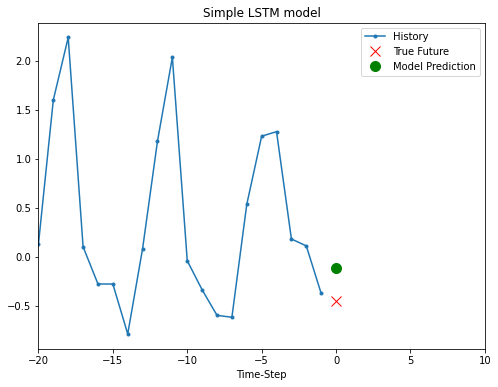

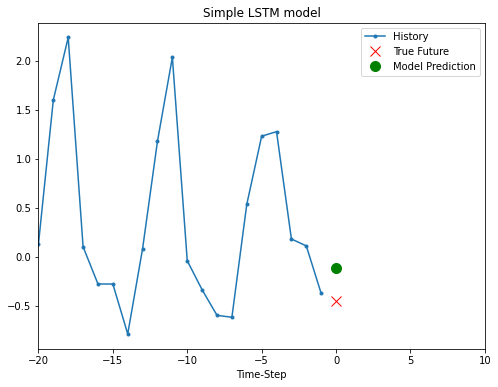

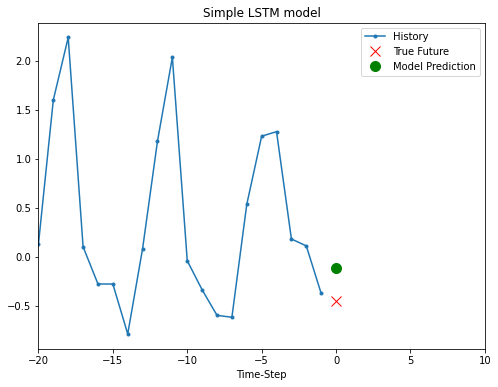

In [0]:
'''Now that we have trained your simple LSTM, let's try and make a few predictions'''

for x, y in val_univariate.take(3):
  plot = show_plot([x[0].numpy(), y[0].numpy(),
                    simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
  plot.show()

# **Part 2: Forecast a multivariate time series**

In [0]:
'''We take the 4 stores in California as our features to consider'''

features_considered = ['CA_1', 'CA_2', 'CA_3', 'CA_4']

In [0]:
features = df1[features_considered]
features.index = df1['Day']
features.head()

,CA_1,CA_2,CA_3,CA_4
Day,,,,
1,4337,3494,4739,1625
2,4155,3046,4827,1777
3,2816,2121,3785,1386
4,3051,2324,4232,1440
5,2630,1942,3817,1536


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f4983af8438>,
      dtype=object)

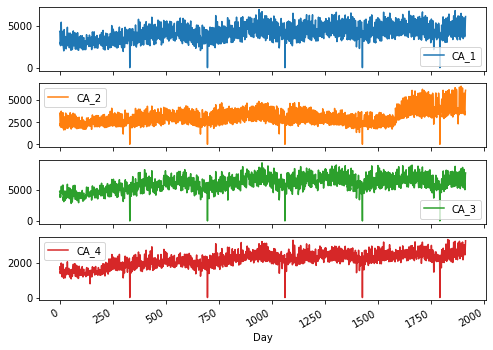

In [0]:
'''Let's have a look at how each of these features vary across time'''

features.plot(subplots=True)

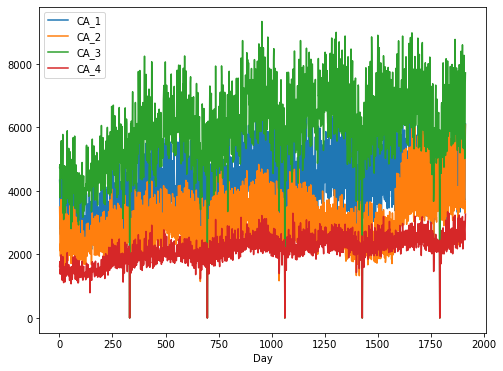

In [0]:
'''Here they are plotted on one graph'''

features.plot()

In [0]:
'''As mentioned, the first step will be to standardize the dataset 
    using the mean and standard deviation of the training data'''

dataset = features.values
data_mean = dataset[:TRAIN_SIZE].mean(axis=0)
data_std = dataset[:TRAIN_SIZE].std(axis=0)

In [0]:
dataset = (dataset-data_mean)/data_std

## **Single Step Model**

In [0]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

In [0]:
past_history = 280
future_target = 28
STEP = 1

x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 1], 0,
                                                   TRAIN_SIZE, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 1], 0,
                                               TRAIN_SIZE, past_history,
                                               future_target, STEP,
                                               single_step=True)


##### THIS IS WHAT IT WAS ON TF TUTORIAL... I CHANGED IT TO THE ABOVE
# past_history = 720
# future_target = 72
# STEP = 6

# x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 1], 0,
#                                                    TRAIN_SPLIT, past_history,
#                                                    future_target, STEP,
#                                                    single_step=True)
# x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 1],
#                                                TRAIN_SPLIT, None, past_history,
#                                                future_target, STEP,
#                                                single_step=True)


In [0]:
'''Let's look at a single data-point'''

print ('Single window of past history : {}'.format(x_train_single[0].shape))

Single window of past history : (280, 4)


In [0]:
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

In [0]:
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(32,
                                           input_shape=x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(1))

single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')

In [0]:
'''Let's check out a sample prediction'''

for x, y in val_data_single.take(1):
  print(single_step_model.predict(x).shape)

(256, 1)


In [0]:
single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=10)

Epoch 1/10
50/50 [==============================] - 11s 229ms/step - loss: 0.7098 - val_loss: 0.6767
Epoch 2/10
50/50 [==============================] - 11s 223ms/step - loss: 0.6347 - val_loss: 0.5777
Epoch 3/10
50/50 [==============================] - 11s 220ms/step - loss: 0.5091 - val_loss: 0.4447
Epoch 4/10
50/50 [==============================] - 11s 220ms/step - loss: 0.4175 - val_loss: 0.3753
Epoch 5/10
50/50 [==============================] - 11s 214ms/step - loss: 0.3660 - val_loss: 0.3368
Epoch 6/10
50/50 [==============================] - 11s 214ms/step - loss: 0.3390 - val_loss: 0.3348
Epoch 7/10
50/50 [==============================] - 11s 218ms/step - loss: 0.3256 - val_loss: 0.3144
Epoch 8/10
50/50 [==============================] - 11s 222ms/step - loss: 0.3187 - val_loss: 0.3101
Epoch 9/10
50/50 [==============================] - 11s 217ms/step - loss: 0.3091 - val_loss: 0.2983
Epoch 10/10
50/50 [==============================] - 11s 223ms/step - loss: 0.3030 - val_lo

In [0]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

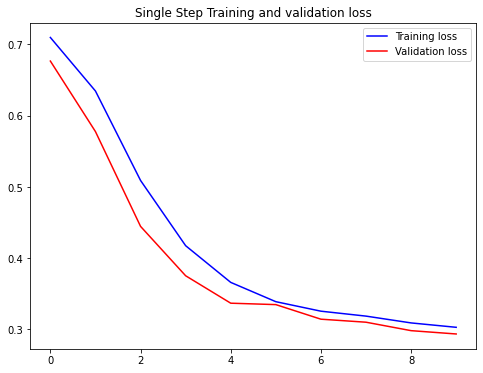

In [0]:
plot_train_history(single_step_history,
                   'Single Step Training and validation loss')

## **Predict a single step future**

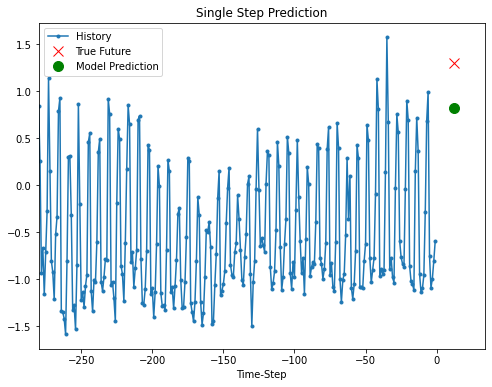

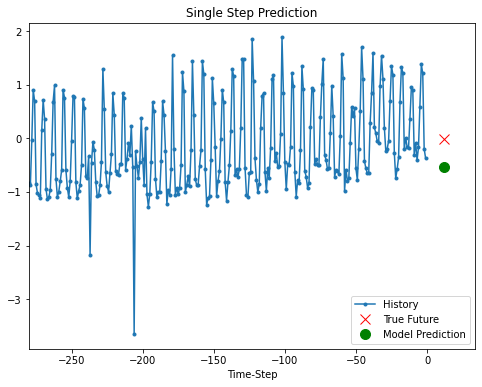

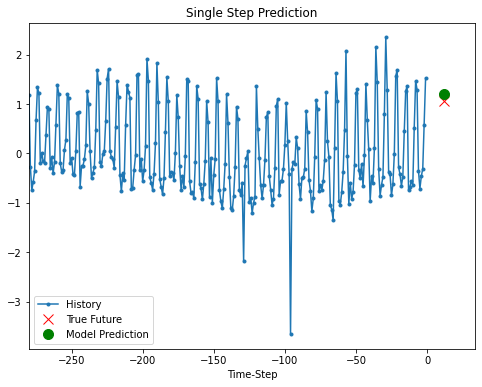

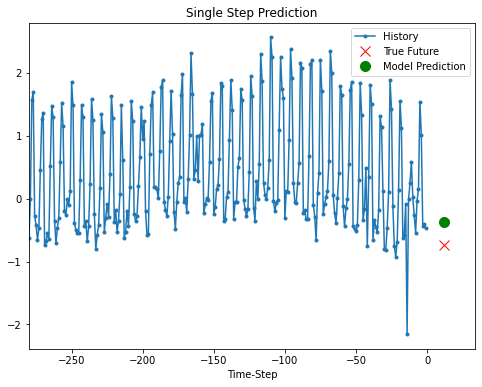

In [0]:
'''Now that the model is trained, let's make a few sample predictions'''

for x, y in val_data_single.take(4):
  plot = show_plot([x[0][:, 1].numpy(), y[0].numpy(),
                    single_step_model.predict(x)[0]], 12,
                   'Single Step Prediction')
  plot.show()

## **Multi-Step model**

In [0]:
'''In a multi-step prediction model, given a past history, 
    the model needs to learn to predict a range of future values.
    Thus, unlike a single step model, where only a single future 
    point is predicted, a multi-step model predict a sequence of 
    the future.'''

future_target = 28
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 1], 0,
                                                 TRAIN_SIZE, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 1], 0,
                                             TRAIN_SIZE, past_history,
                                             future_target, STEP)


### BELOW CODE USED IN TUTORIAL, CHANGED TO THE ABOVE
# future_target = 28
# x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 1], 0,
#                                                  TRAIN_SIZE, past_history,
#                                                  future_target, STEP)
# x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 1],
#                                              TRAIN_SIZE, None, past_history,
#                                              future_target, STEP)

In [0]:
'''Let's check out a sample data-point'''

print ('Single window of past history : {}'.format(x_train_multi[0].shape))
print ('\n Target to predict : {}'.format(y_train_multi[0].shape))

Single window of past history : (280, 4)

 Target to predict : (28,)


In [0]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

In [0]:
'''Plotting a sample data-point'''

def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:, 1]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()

def multi_step_plot_tail(history, true_future, prediction):
  plt.figure(figsize=(18, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:, 1]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.xlim([-10, 30])
  plt.show()

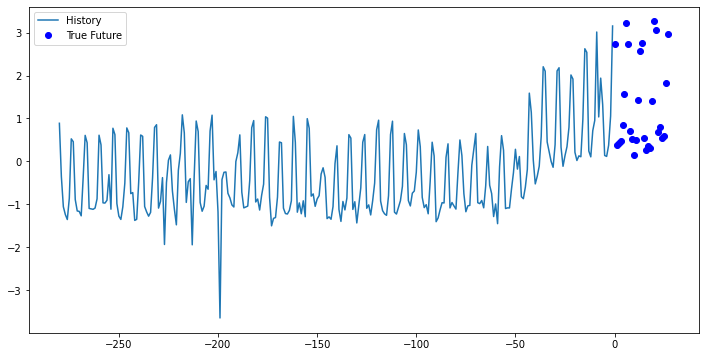

In [0]:
for x, y in train_data_multi.take(1):
  multi_step_plot(x[0], y[0], np.array([0]))

  # we will want to stretch the plot to see the trend between each future step

In [0]:
'''Since the task here is a bit more complicated than the previous task, the model now consists of two LSTM layers'''

multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(28))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

In [0]:
'''Let's see how the model predicts before it trains'''

for x, y in val_data_multi.take(1):
  print(multi_step_model.predict(x).shape)

# print(multi_step_model.predict(x).shape)

(256, 28)


In [0]:
multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=10)

Epoch 1/10
50/50 [==============================] - 20s 403ms/step - loss: 0.7500 - val_loss: 0.7147
Epoch 2/10
50/50 [==============================] - 20s 395ms/step - loss: 0.6973 - val_loss: 0.6713
Epoch 3/10
50/50 [==============================] - 19s 388ms/step - loss: 0.6163 - val_loss: 0.5380
Epoch 4/10
50/50 [==============================] - 19s 390ms/step - loss: 0.5046 - val_loss: 0.4824
Epoch 5/10
50/50 [==============================] - 20s 398ms/step - loss: 0.4491 - val_loss: 0.4376
Epoch 6/10
50/50 [==============================] - 20s 397ms/step - loss: 0.4252 - val_loss: 0.4127
Epoch 7/10
50/50 [==============================] - 20s 401ms/step - loss: 0.4119 - val_loss: 0.4014
Epoch 8/10
50/50 [==============================] - 20s 401ms/step - loss: 0.4049 - val_loss: 0.3834
Epoch 9/10
50/50 [==============================] - 20s 392ms/step - loss: 0.3946 - val_loss: 0.4037
Epoch 10/10
50/50 [==============================] - 20s 397ms/step - loss: 0.3872 - val_lo

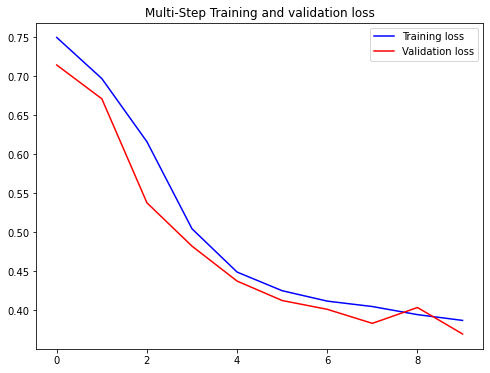

In [0]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

## **Predict a multi-step future**

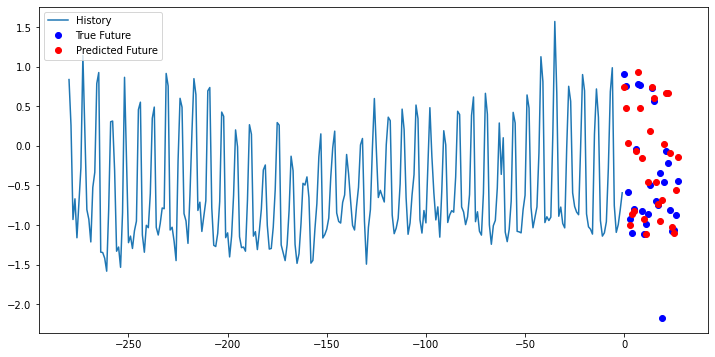

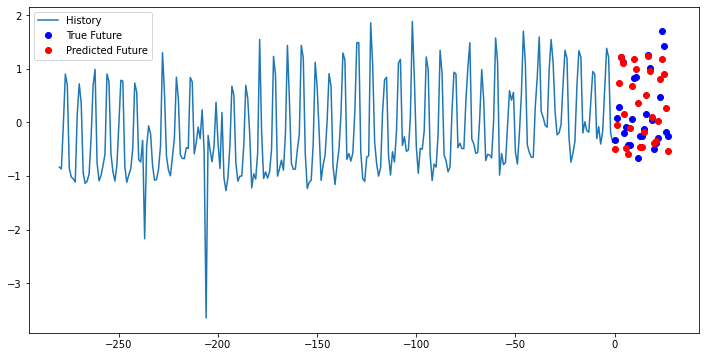

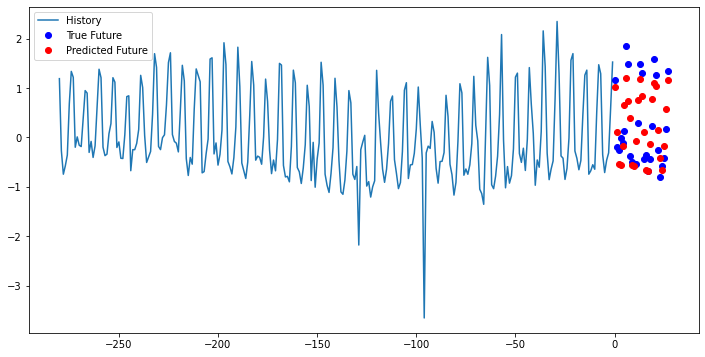

In [0]:
'''Let's now have a look at how well your network has learnt to predict the future'''

for x, y in val_data_multi.take(3):
  multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])

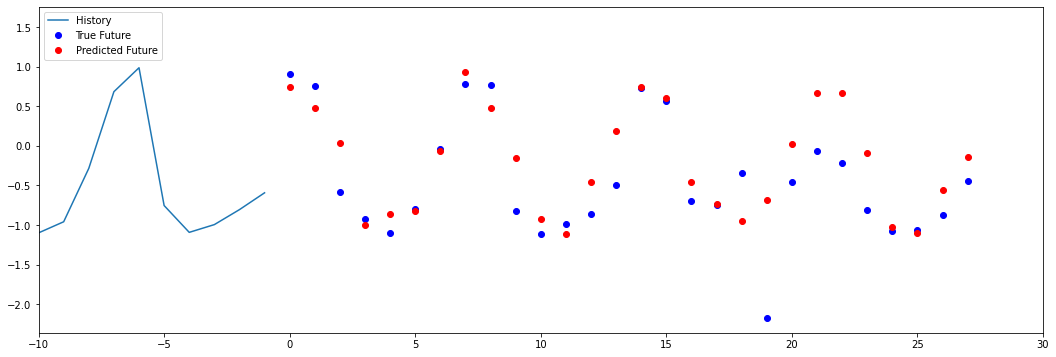

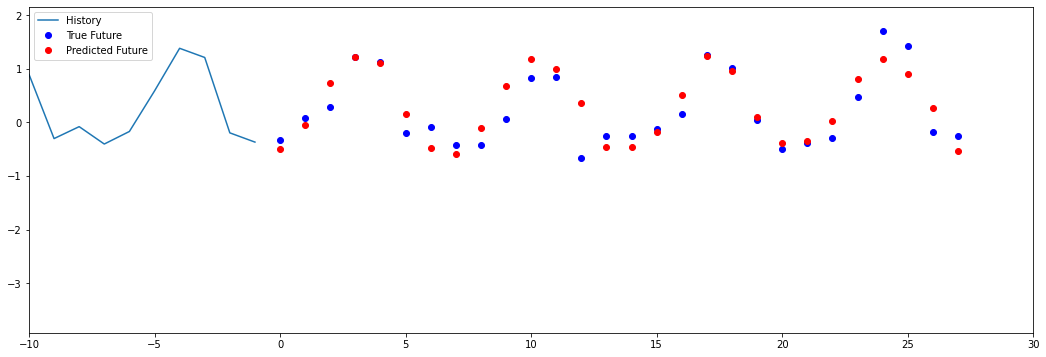

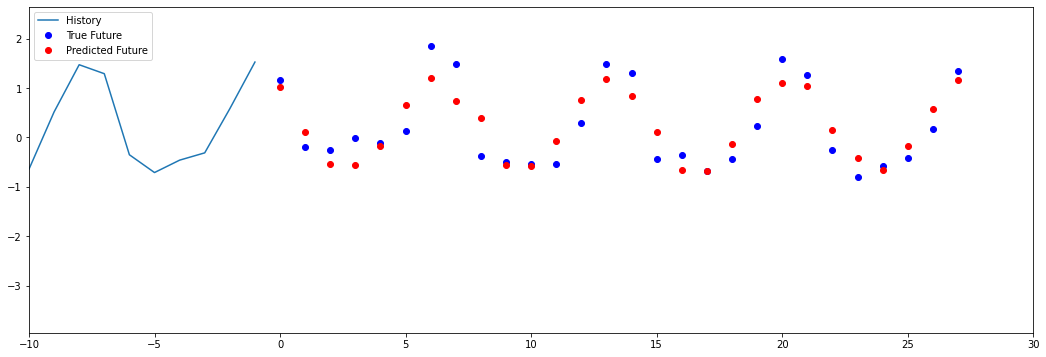

In [0]:
'''Zoom into tail of plot for better visualisation'''

for x, y in val_data_multi.take(3):
  multi_step_plot_tail(x[0], y[0], multi_step_model.predict(x)[0])